## Package Import

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())

# import tensorflow as tf
# import tensorflow_addons as tfa
# from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
# from tensorflow.keras.models import Sequential, Model, load_model
# from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Flatten, Embedding, Concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import FalseNegatives, TruePositives, TrueNegatives, FalsePositives, Precision, Recall
# print("TensorFlow version:", tf.__version__)
# print(tf.config.list_physical_devices('GPU'), '\n')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier
from xgboost import plot_importance as xgb_plot_importance

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier
from lightgbm import plot_importance as lgbm_plot_importance

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
# optuna.logging.set_verbosity(optuna.logging.WARNING)

print(os.getcwd())
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
pd.set_option('mode.chained_assignment', None)

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc, rcParams
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

# 마이너스 깨짐 현상 해결
rcParams['axes.unicode_minus'] = False

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

True 1
d:\Airplane_Delay


## Data Load

In [11]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)

In [12]:
train.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,None
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,None
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,None
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,None
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,None


In [3]:
display(train[train.columns[train.isnull().any()]].info())
display(test[test.columns[test.isnull().any()]].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Estimated_Departure_Time  890981 non-null  float64
 1   Estimated_Arrival_Time    890960 non-null  float64
 2   Origin_State              890985 non-null  object 
 3   Destination_State         890921 non-null  object 
 4   Airline                   891080 non-null  object 
 5   Carrier_Code(IATA)        891010 non-null  object 
 6   Carrier_ID(DOT)           891003 non-null  float64
 7   Delay                     255001 non-null  object 
dtypes: float64(3), object(5)
memory usage: 61.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Estimated_Departure_Time  891016 non-null  float64
 1   Estimated_Arrival_Time    890952 non-null  float64
 2   Origin_State              893495 non-null  object 
 3   Destination_State         893477 non-null  object 
 4   Airline                   893473 non-null  object 
 5   Carrier_Code(IATA)        891007 non-null  object 
 6   Carrier_ID(DOT)           890994 non-null  float64
dtypes: float64(3), object(4)
memory usage: 53.4+ MB


None

## Data Preprocessing

### Missing Value Handling

#### `Estimated_Departure_Time`, `Estimated_Arrival_Time` 결측치 대체
- **`IterativeImputer`** 를 사용하여 결측치 대체

In [4]:
# 대체할 열의 이름을 'Estimated_Departure_Time' 및 'Estimated_Arrival_Time'으로 정의합니다.
estimated_time_col = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']

# IterativeImputer 객체를 생성합니다.
# - Lasso() 추정기(예측 모델)를 사용하여 누락된 값을 대체합니다.
# - 초기 전략은 'most_frequent'로 설정됩니다. (가장 자주 나오는 값으로 초기화)
# - missing_values 매개변수를 사용하여 결측치를 지정합니다.
# - max_iter 매개변수를 사용하여 최대 반복 횟수를 1000으로 설정합니다.
# - imputation_order는 'roman'으로 설정되어 순서대로 대체합니다.
# - random_state는 SEED(임의의 시드 값)로 설정되어 랜덤성을 제어합니다.
imp = IterativeImputer(estimator=Lasso(), initial_strategy='most_frequent', missing_values=np.nan,
                       max_iter=1000, imputation_order='roman', random_state=SEED)

# IterativeImputer를 사용하여 누락된 값을 대체하고, 그 결과를 train 데이터프레임의 해당 열에 할당합니다.
train[estimated_time_col] = imp.fit_transform(train[estimated_time_col])

# 대체된 값을 반올림하여 정수로 변환합니다.
train[estimated_time_col] = np.round(train[estimated_time_col])

# 대체 후에 'Estimated_Departure_Time' 및 'Estimated_Arrival_Time' 열에서 여전히 결측치인 행의 수를 출력합니다.
print(train['Estimated_Departure_Time'].isnull().sum(), train['Estimated_Arrival_Time'].isnull().sum())

0 0


#### `Origin_State`, `Destination_State` 결측치 대체
- `Origin_State` : `Origin_Airport` & `Origin_Airport_ID`으로 그룹화하여 최빈값으로 대체
- `Destination_State` : `Destination_Airport` & `Destination_Airport_ID`으로 그룹화하여 최빈값으로 대체

In [5]:
train['Origin_State'] = train.groupby(['Origin_Airport', 'Origin_Airport_ID'])['Origin_State'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(train['Origin_State'].mode()[0]))
train['Destination_State'] = train.groupby(['Destination_Airport', 'Destination_Airport_ID'])['Destination_State'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(train['Destination_State'].mode()[0]))
print(train['Origin_State'].isnull().sum(), train['Destination_State'].isnull().sum())

0 0


#### `Airline`, `Carrier_Code(IATA)`, `Carrier_ID(DOT)` 결측치 대체
- `Airline` : `Tail_Number`로 그룹화하여 최빈값으로 대체
- `Carrier_Code(IATA)` : `Airline`으로 그룹화하여 최빈값으로 대체 (`Airline`과 1:1 or 1:N 대응)
- `Carrier_ID(DOT)` : `Airline`으로 그룹화하여 최빈값으로 대체 (`Airline`과 1:1 대응)

In [6]:
train['Airline'] = train.groupby(['Tail_Number'], as_index = False)['Airline'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(train['Airline'].mode()[0]))
train['Carrier_Code(IATA)'] = train.groupby(['Airline'], as_index = False)['Carrier_Code(IATA)'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(train['Carrier_Code(IATA)'].mode()[0]))
train['Carrier_ID(DOT)'] = train.groupby(['Airline'], as_index = False)['Carrier_ID(DOT)'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(train['Carrier_ID(DOT)'].mode()[0]))

print(train['Airline'].isnull().sum(), train['Carrier_Code(IATA)'].isnull().sum(), train['Carrier_ID(DOT)'].isnull().sum())

0 0 0


### Feature Engineering

#### `Day` 변수 생성
- `Month` & `Day_of_Month` 변수를 사용하여 365일 형태로 표현

In [7]:
def To_Days(x):
    month_to_days = {1:0, 2:31, 3:60, 4:91, 5:121, 6:152, 7:182, 8:213, 9:244, 10:274, 11:305, 12:335}
    return month_to_days[x]

train['Day'] = train['Month'].apply(lambda x: To_Days(x))
train['Day'] = train['Day'] + train['Day_of_Month']

#### `Flight_Time` & `km/h`  / `DT_Bin` & `AT_Bin` 변수 생성
- 1) `Distance` 단위 변환 (mile -> km)
- 2) `Dep_Time` & `Arr_Time` : `Estimated_Departure_Time`과 `Estimated_Arrival_Time`을 시간 단위로 계산
- 3) `DT_Bin` & `AT_Bin` : `Dep_Time` & `Arr_Time`을 30분 단위로 48개의 bin에 담아서 object화
- 4) 출발 시간이 도착 시간보다 값이 큰 경우 (`Dep_Time` > `Arr_Time`) => `Arr_Time`에 24시간을 더해줌
- 5) `Flight_Time` : 항공기 운행 시간 (`Arr_Time` - `Dep_Time`)
- 6) `km/h` : 항공기 운행 속력 (`Distance` / `Flight_time`)

In [8]:
train['Distance'] = train['Distance'] * 1.609

train['Dep_Time'] = (train['Estimated_Departure_Time'] // 100) + ((train['Estimated_Departure_Time'] % 100) / 60)
train['Arr_Time'] = (train['Estimated_Arrival_Time'] // 100) + ((train['Estimated_Arrival_Time'] % 100) / 60)

In [9]:
time_col = ['Dep_Time', 'Arr_Time']
names = {'Dep_Time' : 'DT_Bin', 'Arr_Time' : 'AT_Bin'}

for ET in time_col :
    for i in range(48) : 
        train.loc[train[ET].between(i/2, (i + 1)/2, 'left'), names[ET]] = i
        train.loc[train[ET] == 24, names[ET]] = 47
train = train.astype({'DT_Bin' : int, 'AT_Bin' : int})

In [10]:
condition = train['Dep_Time'] >= train['Arr_Time']
train.loc[condition, 'Arr_Time'] += 24

train['Flight_Time'] = train['Arr_Time'] - train['Dep_Time']
train['km/h'] = train['Distance'] / train['Flight_Time']

# Q1, Q3 = train['km/h'].quantile(0.25), train['km/h'].quantile(0.75)
# IQR = Q3 - Q1
# MIN, MAX = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
# 
# train.loc[(train['km/h'] < MIN), 'km/h'] = MIN
# train.loc[(train['km/h'] > MAX), 'km/h'] = MAX

#### `Season` 변수 생성

In [11]:
def Get_Season(x) :
    if x in [12, 1, 2] :
        return 'Winter'
    elif x in [3, 4, 5] :
        return 'Spring'
    elif x in [6, 7, 8] :
        return 'Summer'
    else :
        return 'Fall'
    
train['Season'] = train['Month'].apply(Get_Season)

#### `Peak_time` 변수 생성

In [12]:
def Get_Peak_time(x) :
    if x in [0, 1, 2, 3, 4, 5, 21, 22, 23]  :
        return 'Peak-Off'
    else :
        return 'Peak-Hour'
    
train['Peak_time'] = train['Dep_Time'].astype('int').apply(Get_Peak_time)

#### `Same_State` 변수 생성 (동일한 지역)

In [13]:
train['Same_State'] = train['Origin_State'] == train['Destination_State']

def Get_Same_State(x) :
    
    if x == True:
        return 'Same Area' 
    else :
        return 'Other Area'
    
train['Same_State'] = train['Same_State'].apply(Get_Same_State)

#### `O_Area`, `D_Area` 변수 생성
- `Origin_State`, `Destination_State` 지부 별로 분할
- `북동부(Northeast)` : `0` /  `중서부(Midwest)` : `1`   /  `남부(South)` : `2`  /  `서부(West)` : `3` / `기타` : `4`

In [14]:
def Get_O_Area(x) :
    if x in ['Maine', 'Vermont', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Maryland', 'Virginia', 'West Virginia'] :
        return 'Northeast_O'
    elif x in ['Texas', 'Oklahoma', 'Alabama', 'Arkansas', 'Louisiana', 'Mississippi', 'Tennessee', 'Kentucky', 'Georgia', 'Florida', 'South Carolina', 'North Carolina'] :
        return 'Midwest_O'
    elif x in ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Indiana', 'Illinois', 'Missouri', 'Ohio', 'Michigan']:
        return 'South_O'
    elif x in ['U.S. Pacific Trust Territories and Possessions', 'U.S. Virgin Islands', 'Puerto Rico'] :
        return 'Other_O'
    else :
        return 'West_O'
    
def Get_D_Area(x) :
    if x in ['Maine', 'Vermont', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Maryland', 'Virginia', 'West Virginia'] :
        return 'Northeast_D'
    elif x in ['Texas', 'Oklahoma', 'Alabama', 'Arkansas', 'Louisiana', 'Mississippi', 'Tennessee', 'Kentucky', 'Georgia', 'Florida', 'South Carolina', 'North Carolina'] :
        return 'Midwest_D'
    elif x in ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Indiana', 'Illinois', 'Missouri', 'Ohio', 'Michigan']:
        return 'South_D'
    elif x in ['U.S. Pacific Trust Territories and Possessions', 'U.S. Virgin Islands', 'Puerto Rico'] :
        return 'Other_D'
    else :
        return 'West_D'
    
train['O_Area'] = train['Origin_State'].apply(Get_O_Area)
train['D_Area'] = train['Destination_State'].apply(Get_D_Area)

#### `OD_Airport`  & `OD_State` 변수 생성

In [15]:
train['OD_Airport'] = train['Origin_Airport'] + '-' + train['Destination_Airport']
train['OD_State'] = train['Origin_State'] + '-' + train['Destination_State']

## EDA

### `Month`별 Delay 비율

In [16]:
train_month = train.groupby('Month', as_index = False)['Delay'].value_counts()
train_month = train_month.pivot(index = 'Month', columns = 'Delay', values = 'count')
train_month.columns.name = False
train_month.reset_index(inplace = True)
train_month['Delay_Ratio'] = (train_month['Delayed'] / (train_month['Delayed'] + train_month['Not_Delayed'])).round(3)
train_month['Season'] = train_month['Month'].apply(Get_Season)
train_month

,Month,Delayed,Not_Delayed,Delay_Ratio,Season
0,1,3348,16531,0.168,Winter
1,2,3089,11731,0.208,Winter
2,3,3108,15613,0.166,Spring
3,4,3474,17877,0.163,Spring
4,5,3629,15266,0.192,Spring
5,6,3906,13671,0.222,Summer
6,7,4040,15489,0.207,Summer
7,8,4364,17699,0.198,Summer
8,9,3563,21597,0.142,Fall
9,10,3835,22568,0.145,Fall


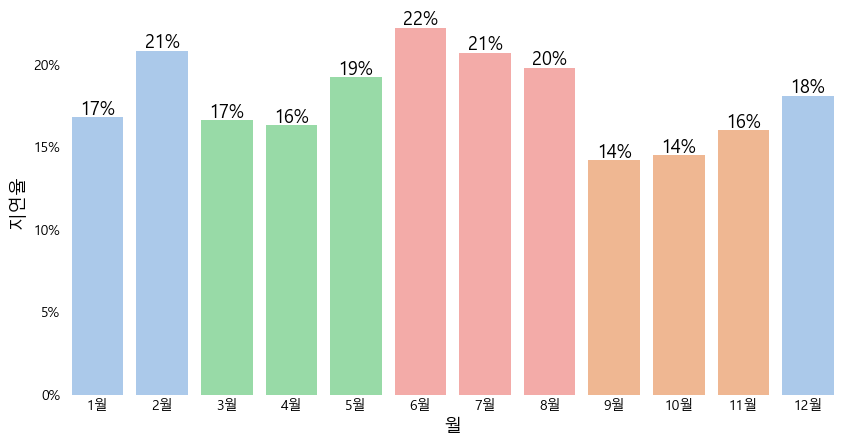

In [17]:
import matplotlib.ticker as ticker

plt.figure(figsize = (10, 5))
palette = sns.color_palette(['#a1c9f4', '#8de5a1', '#ff9f9b', '#ffb482'])
ax = sns.barplot(data = train_month, x = 'Month', y = 'Delay_Ratio', hue = 'Season', dodge = False, palette = palette)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_xticklabels([f"{i}월" for i in range(1, 13)])
ax.set_xlabel('월', fontsize = 13)
ax.set_ylabel('지연율', fontsize = 13)
# ax.set(xlabel = '월', ylabel = '지연율')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis = 'x', length = 0)
ax.tick_params(axis = 'y', length = 0)
ax.legend().remove()

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('{:.0%}'.format(height), (left + width / 2, height * 1.01),
                ha = 'center', fontsize = 13)
# plt.title('월별 항공기 지연율')

plt.show()

### `Season`별 Delay 비율

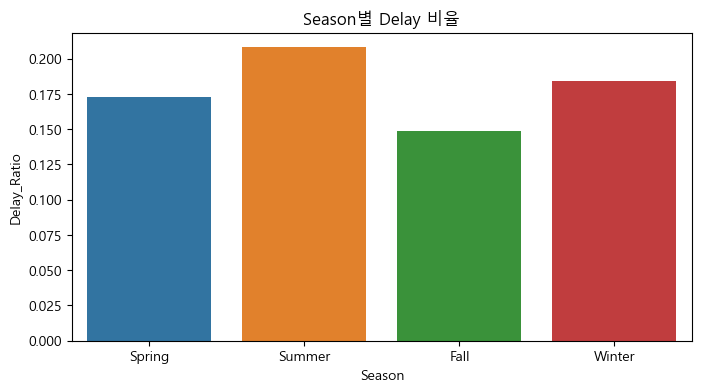

In [18]:
train_season = train.groupby('Season', as_index = False)['Delay'].value_counts()
train_season = train_season.pivot(index = 'Season', columns = 'Delay', values = 'count')
train_season.columns.name = False
train_season.reset_index(inplace = True)
train_season['Delay_Ratio'] = (train_season['Delayed'] / (train_season['Delayed'] + train_season['Not_Delayed'])).round(3)

plt.figure(figsize = (8, 4))
sns.barplot(data = train_season, x = 'Season', y = 'Delay_Ratio', order = ['Spring', 'Summer', 'Fall', 'Winter'])
plt.title('Season별 Delay 비율')
plt.show()

### `Origin_Airport`별 Delay 비율

In [19]:
train_OA = train.groupby('Origin_Airport', as_index = False)['Delay'].value_counts()
train_OA = train_OA.pivot(index = 'Origin_Airport', columns = 'Delay', values = 'count')
train_OA.fillna(0, inplace = True)
train_OA.columns.name = None
train_OA.reset_index(inplace = True)
train_OA['Delay_Ratio'] = (train_OA['Delayed'] / (train_OA['Delayed'] + train_OA['Not_Delayed'])).round(3)
train_OA.sort_values(by = 'Delay_Ratio', ascending = False, inplace = True)
train_OA

,Origin_Airport,Delayed,Not_Delayed,Delay_Ratio
249,OGD,3.0,2.0,0.6
259,OTH,6.0,4.0,0.6
251,OGS,5.0,5.0,0.5
280,PPG,1.0,1.0,0.5
153,HGR,1.0,1.0,0.5
...,...,...,...,...
261,OWB,0.0,4.0,0.0
334,SMX,0.0,7.0,0.0
340,STC,0.0,3.0,0.0
275,PIH,0.0,33.0,0.0


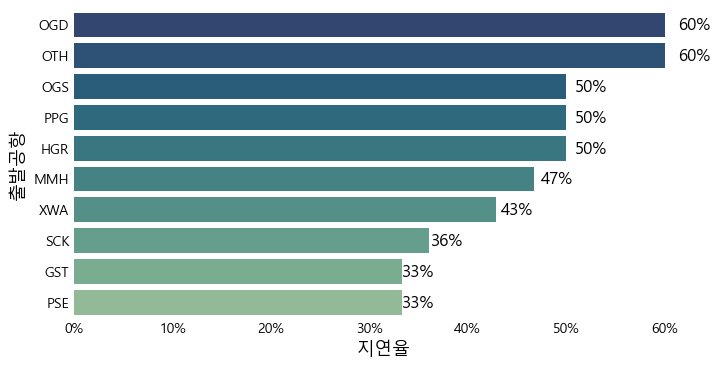

In [20]:
train_OA_top10 = train_OA.head(10)

plt.figure(figsize = (8, 4))
ax = sns.barplot(data = train_OA_top10, x = 'Delay_Ratio', y = 'Origin_Airport', palette = 'crest_r')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.set_xlabel('지연율', fontsize = 13)
ax.set_ylabel('출발공항', fontsize = 13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis = 'x', length = 0)
ax.tick_params(axis = 'y', length = 0)

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('{:.0%}'.format(width), (width * 1.05, (height * 0.7 + bottom)),
                ha = 'center', fontsize = 12)
# plt.title('항공기 출발지별 지연율 Top 10')
plt.show()

### `Origin_State`별 Delay 비율

In [21]:
train_OS = train.groupby('Origin_State', as_index = False)['Delay'].value_counts()
train_OS = train_OS.pivot(index = 'Origin_State', columns = 'Delay', values = 'count')
train_OS.fillna(0, inplace = True)
train_OS.columns.name = None
train_OS.reset_index(inplace = True)
train_OS['Delay_Ratio'] = (train_OS['Delayed'] / (train_OS['Delayed'] + train_OS['Not_Delayed'])).round(3)
train_OS.sort_values(by = 'Delay_Ratio', ascending = False, inplace = True)
train_OS

,Origin_State,Delayed,Not_Delayed,Delay_Ratio
28,New Jersey,1428,4376,0.246
11,Illinois,3577,12586,0.221
37,Puerto Rico,211,815,0.206
19,Massachusetts,1054,4075,0.205
30,New York,2541,9962,0.203
...,...,...,...,...
10,Idaho,126,966,0.115
1,Alaska,147,1234,0.106
43,U.S. Pacific Trust Territories and Possessions,7,63,0.100
9,Hawaii,396,4129,0.088


### `Destination_Airport`별 Delay 비율

In [22]:
train_DA = train.groupby('Destination_Airport', as_index = False)['Delay'].value_counts()
train_DA = train_DA.pivot(index = 'Destination_Airport', columns = 'Delay', values = 'count')
train_DA.fillna(0, inplace = True)
train_DA.columns.name = None
train_DA.reset_index(inplace = True)
train_DA['Delay_Ratio'] = (train_DA['Delayed'] / (train_DA['Delayed'] + train_DA['Not_Delayed'])).round(3)
train_DA.sort_values(by = 'Delay_Ratio', ascending = False, inplace = True)
train_DA

,Destination_Airport,Delayed,Not_Delayed,Delay_Ratio
103,DUT,7.0,10.0,0.412
96,DIK,10.0,17.0,0.370
42,BLV,12.0,21.0,0.364
317,SCK,10.0,18.0,0.357
279,PPG,1.0,2.0,0.333
...,...,...,...,...
110,EKO,0.0,23.0,0.000
53,BTM,0.0,17.0,0.000
248,OGD,0.0,3.0,0.000
97,DLG,0.0,2.0,0.000


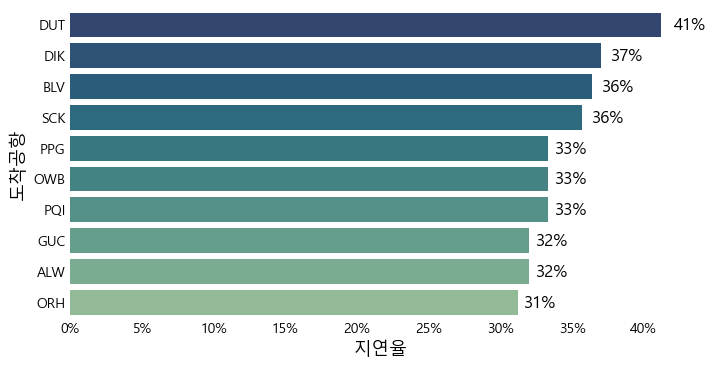

In [23]:
train_DA_top10 = train_DA.head(10)

plt.figure(figsize = (8, 4))
ax = sns.barplot(data = train_DA_top10, x = 'Delay_Ratio', y = 'Destination_Airport', palette = 'crest_r')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.set_xlabel('지연율', fontsize = 13)
ax.set_ylabel('도착공항', fontsize = 13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis = 'x', length = 0)
ax.tick_params(axis = 'y', length = 0)

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('{:.0%}'.format(width), (width * 1.05, (height * 0.7 + bottom)),
                ha = 'center', fontsize = 12)
# plt.title('항공기 출발지별 지연율 Top 10')
plt.show()

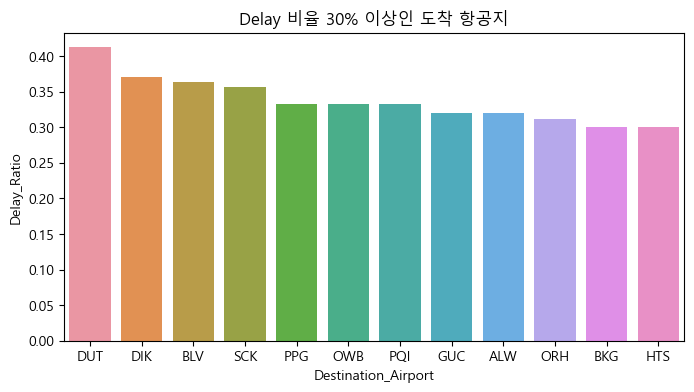

In [24]:
train_DA_over03 = train_DA[train_DA['Delay_Ratio'] >= 0.3]

plt.figure(figsize = (8, 4))
sns.barplot(data = train_DA_over03, x = 'Destination_Airport', y = 'Delay_Ratio')
plt.title('Delay 비율 30% 이상인 도착 항공지')
plt.show()

### `Destination_State`별 Delay 비율

In [25]:
train_DS = train.groupby('Destination_State', as_index = False)['Delay'].value_counts()
train_DS = train_DS.pivot(index = 'Destination_State', columns = 'Delay', values = 'count')
train_DS.fillna(0, inplace = True)
train_DS.columns.name = None
train_DS.reset_index(inplace = True)
train_DS['Delay_Ratio'] = (train_DS['Delayed'] / (train_DS['Delayed'] + train_DS['Not_Delayed'])).round(3)
train_DS.sort_values(by = 'Delay_Ratio', ascending = False, inplace = True)
train_DS

,Destination_State,Delayed,Not_Delayed,Delay_Ratio
28,New Jersey,1619,4154,0.280
49,West Virginia,59,195,0.232
37,Puerto Rico,227,768,0.228
19,Massachusetts,1125,3955,0.221
30,New York,2691,9717,0.217
...,...,...,...,...
45,Utah,511,3222,0.137
35,Oregon,484,3312,0.128
10,Idaho,130,894,0.127
1,Alaska,169,1214,0.122


### `Airline`별 Delay 비율

In [26]:
train_AL = train.groupby('Airline', as_index = False)['Delay'].value_counts()
train_AL = train_AL.pivot(index = 'Airline', columns = 'Delay', values = 'count')
train_AL.fillna(0, inplace = True)
train_AL.columns.name = None
train_AL.reset_index(inplace = True)
train_AL['Delay_Ratio'] = (train_AL['Delayed'] / (train_AL['Delayed'] + train_AL['Not_Delayed'])).round(3)
train_AL.sort_values(by = 'Delay_Ratio', ascending = False, inplace = True)
train_AL.head(10)

,Airline,Delayed,Not_Delayed,Delay_Ratio
20,Peninsula Airways Inc.,10,24,0.294
7,"Commutair Aka Champlain Enterprises, Inc.",524,1315,0.285
14,Frontier Airlines Inc.,1202,3575,0.252
18,JetBlue Airways,2813,8583,0.247
25,Trans States Airlines,564,1996,0.220
13,ExpressJet Airlines Inc.,1104,4557,0.195
27,Virgin America,67,283,0.191
2,Allegiant Air,740,3142,0.191
3,American Airlines Inc.,4393,18936,0.188
23,Southwest Airlines Co.,9733,42015,0.188


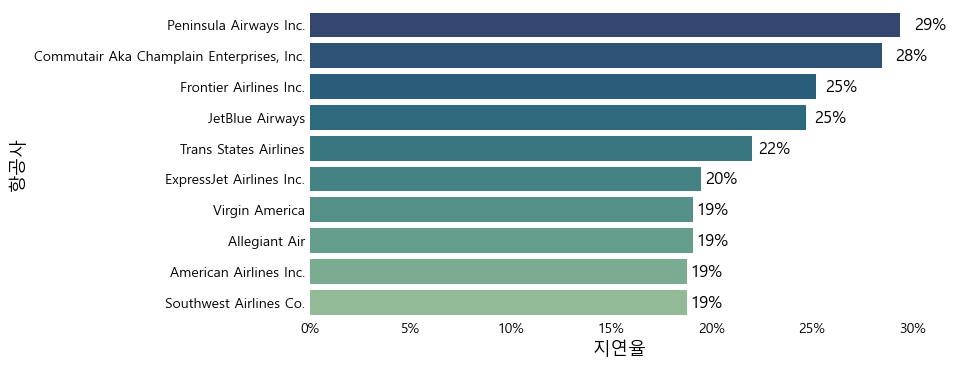

In [27]:
train_AL_top10 = train_AL.head(10)

plt.figure(figsize = (8, 4))
ax = sns.barplot(data = train_AL_top10, x = 'Delay_Ratio', y = 'Airline', palette = 'crest_r')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.set_xlabel('지연율', fontsize = 13)
ax.set_ylabel('항공사', fontsize = 13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis = 'x', length = 0)
ax.tick_params(axis = 'y', length = 0)

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('{:.0%}'.format(width), (width * 1.05, (height * 0.7 + bottom)),
                ha = 'center', fontsize = 12)
# plt.title('항공기 출발지별 지연율 Top 10')
plt.show()

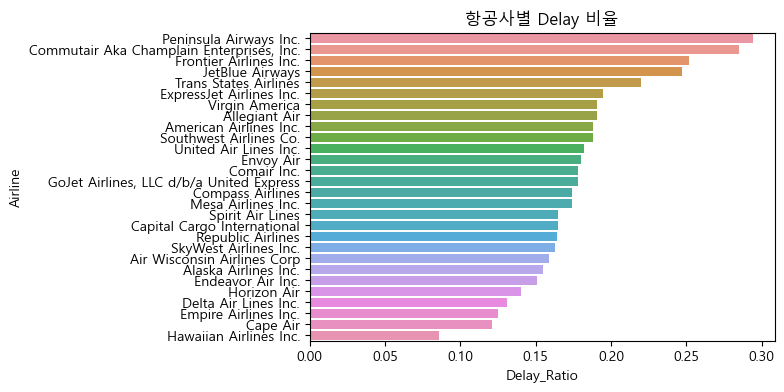

In [28]:
plt.figure(figsize = (6, 4))
sns.barplot(data = train_AL, x = 'Delay_Ratio', y = 'Airline')
plt.title('항공사별 Delay 비율')
plt.show()

### `OD_Airport`별 Delay 비율

In [29]:
train_ODA = train.groupby('OD_Airport', as_index = False)['Delay'].value_counts()
train_ODA = train_ODA.pivot(index = 'OD_Airport', columns = 'Delay', values = 'count')
train_ODA.fillna(0, inplace = True)
train_ODA.columns.name = None
train_ODA.reset_index(inplace = True)
train_ODA['Delay_Ratio'] = (train_ODA['Delayed'] / (train_ODA['Delayed'] + train_ODA['Not_Delayed'])).round(3)
train_ODA.sort_values(by = 'Delay_Ratio', ascending = False, inplace = True)
train_ODA

,OD_Airport,Delayed,Not_Delayed,Delay_Ratio
433,AZA-RDM,1.0,0.0,1.0
5649,SFO-BDL,1.0,0.0,1.0
2886,JAX-AUS,2.0,0.0,1.0
5828,SJU-PIT,1.0,0.0,1.0
606,BNA-RIC,2.0,0.0,1.0
...,...,...,...,...
359,AUS-PVD,0.0,2.0,0.0
4930,PIT-CHS,0.0,1.0,0.0
358,AUS-PIT,0.0,4.0,0.0
763,BUR-BNA,0.0,1.0,0.0


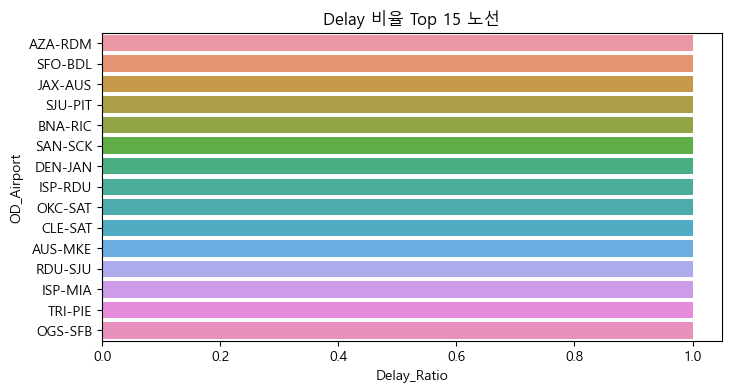

In [30]:
train_ODA_top15 = train_ODA.head(15)

plt.figure(figsize = (8, 4))
sns.barplot(data = train_ODA_top15, x = 'Delay_Ratio', y = 'OD_Airport')
plt.title('Delay 비율 Top 15 노선')
plt.show()

### `OD_State`별 Delay 비율

In [31]:
train_ODS = train.groupby('OD_State', as_index = False)['Delay'].value_counts()
train_ODS = train_ODS.pivot(index = 'OD_State', columns = 'Delay', values = 'count')
train_ODS.fillna(0, inplace = True)
train_ODS.columns.name = None
train_ODS.reset_index(inplace = True)
train_ODS['Delay_Ratio'] = (train_ODS['Delayed'] / (train_ODS['Delayed'] + train_ODS['Not_Delayed'])).round(3)
train_ODS.sort_values(by = 'Delay_Ratio', ascending = False, inplace = True)
train_ODS

,OD_State,Delayed,Not_Delayed,Delay_Ratio
1150,U.S. Virgin Islands-Texas,1.0,0.0,1.0
142,Colorado-Mississippi,3.0,0.0,1.0
1024,Rhode Island-Louisiana,1.0,0.0,1.0
744,New Jersey-Alaska,2.0,0.0,1.0
437,Kentucky-Washington,1.0,0.0,1.0
...,...,...,...,...
162,Colorado-Vermont,0.0,1.0,0.0
399,Iowa-Utah,0.0,11.0,0.0
397,Iowa-Tennessee,0.0,1.0,0.0
394,Iowa-New York,0.0,8.0,0.0


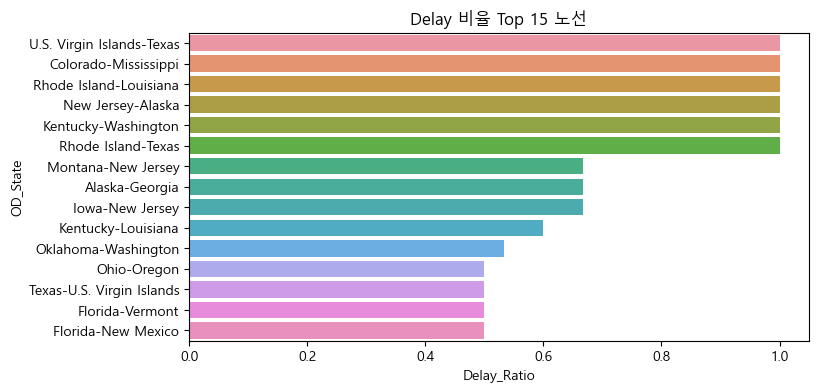

In [32]:
train_ODS_top15 = train_ODS.head(15)

plt.figure(figsize = (8, 4))
sns.barplot(data = train_ODS_top15, x = 'Delay_Ratio', y = 'OD_State')
plt.title('Delay 비율 Top 15 노선')
plt.show()

### `Distance` 분포

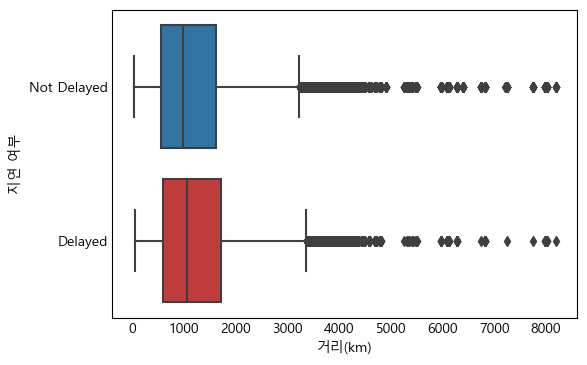

In [33]:
plt.figure(figsize = (6, 4))
ax = sns.boxplot(x = train['Distance'], y = train['Delay'], palette = sns.color_palette(['#1f77b4', '#d62728'], 2))
ax.set(xlabel = '거리(km)', ylabel = '지연 여부')
ax.set_yticklabels(['Not Delayed', 'Delayed'])
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis = 'x', length = 0)
ax.tick_params(axis = 'y', length = 0)

# plt.title('비행 거리에 따른 항공기 지연 여부')
plt.show()

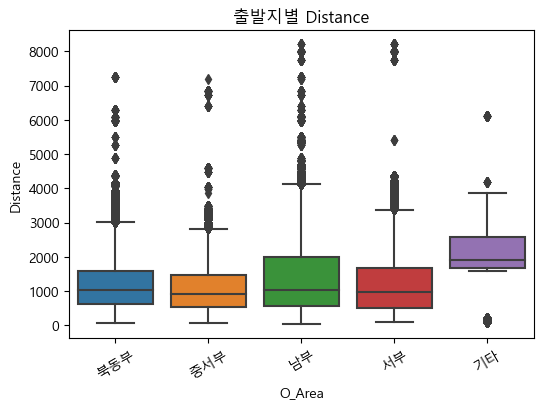

In [34]:
plt.figure(figsize = (6, 4))
ax = sns.boxplot(x = train['O_Area'], y = train['Distance'])
plt.xticks([0, 1, 2, 3, 4], ['북동부', '중서부', '남부', '서부', '기타'], rotation = 30)
plt.title('출발지별 Distance')
plt.show()

## 변수 선택

In [35]:
train_OA = train_OA[['Origin_Airport', 'Delay_Ratio']].rename({'Delay_Ratio' : 'OA_Delay_Ratio'}, axis = 1)
train_OS = train_OS[['Origin_State', 'Delay_Ratio']].rename({'Delay_Ratio' : 'OS_Delay_Ratio'}, axis = 1)
train_DA = train_DA[['Destination_Airport', 'Delay_Ratio']].rename({'Delay_Ratio' : 'DA_Delay_Ratio'}, axis = 1)
train_DS = train_DS[['Destination_State', 'Delay_Ratio']].rename({'Delay_Ratio' : 'DS_Delay_Ratio'}, axis = 1)
train_AL = train_AL[['Airline', 'Delay_Ratio']].rename({'Delay_Ratio' : 'AL_Delay_Ratio'}, axis = 1)
train_ODA = train_ODA[['OD_Airport', 'Delay_Ratio']].rename({'Delay_Ratio' : 'ODA_Delay_Ratio'}, axis = 1)
train_ODS = train_ODS[['OD_State', 'Delay_Ratio']].rename({'Delay_Ratio' : 'ODS_Delay_Ratio'}, axis = 1)

In [36]:
train_OA_final = pd.merge(train[['Origin_Airport']], train_OA, how = 'left', on = 'Origin_Airport')
train_OS_final = pd.merge(train[['Origin_State']], train_OS, how = 'left', on = 'Origin_State')
train_DA_final = pd.merge(train[['Destination_Airport']], train_DA, how = 'left', on = 'Destination_Airport')
train_DS_final = pd.merge(train[['Destination_State']], train_DS, how = 'left', on = 'Destination_State')
train_AL_final = pd.merge(train[['Airline']], train_AL, how = 'left', on = 'Airline')
train_ODA_final = pd.merge(train[['OD_Airport']], train_ODA, how = 'left', on = 'OD_Airport')
train_ODS_final = pd.merge(train[['OD_State']], train_ODS, how = 'left', on = 'OD_State')

In [37]:
print(train_OA_final['OA_Delay_Ratio'].isnull().sum(),
      train_OS_final['OS_Delay_Ratio'].isnull().sum(),
      train_DA_final['DA_Delay_Ratio'].isnull().sum(),
      train_DS_final['DS_Delay_Ratio'].isnull().sum(),
      train_AL_final['AL_Delay_Ratio'].isnull().sum(),
      train_ODA_final['ODA_Delay_Ratio'].isnull().sum(),
      train_ODS_final['ODS_Delay_Ratio'].isnull().sum())

0 0 4 0 0 1020 107


In [38]:
train_OA_final['OA_Delay_Ratio'] = train_OA_final['OA_Delay_Ratio'].fillna(train_OA_final['OA_Delay_Ratio'].median())
train_OS_final['OS_Delay_Ratio'] = train_OS_final['OS_Delay_Ratio'].fillna(train_OS_final['OS_Delay_Ratio'].median())
train_DA_final['DA_Delay_Ratio'] = train_DA_final['DA_Delay_Ratio'].fillna(train_DA_final['DA_Delay_Ratio'].median())
train_DS_final['DS_Delay_Ratio'] = train_DS_final['DS_Delay_Ratio'].fillna(train_DS_final['DS_Delay_Ratio'].median())
train_AL_final['AL_Delay_Ratio'] = train_AL_final['AL_Delay_Ratio'].fillna(train_AL_final['AL_Delay_Ratio'].median())
train_ODA_final['ODA_Delay_Ratio'] = train_ODA_final['ODA_Delay_Ratio'].fillna(train_ODA_final['ODA_Delay_Ratio'].median())
train_ODS_final['ODS_Delay_Ratio'] = train_ODS_final['ODS_Delay_Ratio'].fillna(train_ODS_final['ODS_Delay_Ratio'].median())

In [39]:
train_new = pd.concat([train, train_OA_final['OA_Delay_Ratio'], train_OS_final['OS_Delay_Ratio'],
                       train_DA_final['DA_Delay_Ratio'], train_DS_final['DS_Delay_Ratio'],
                       train_AL_final['AL_Delay_Ratio'], train_ODA_final['ODA_Delay_Ratio'], train_ODS_final['ODS_Delay_Ratio']], axis = 1)
train_new['Delay_weight'] = train_new[train_new.columns[train_new.columns.str.contains('Ratio')]].sum(axis = 1)

print(train_new['Delay_weight'].min(), train_new['Delay_weight'].max())

# train_new.drop(columns = train_new.columns[train_new.columns.str.contains('Ratio')], inplace = True)
train_new.head()

0.47700000000000004 2.956


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,...,Season,Peak_time,Same_State,O_Area,D_Area,OD_Airport,OD_State,OA_Delay_Ratio,OS_Delay_Ratio,DA_Delay_Ratio,DS_Delay_Ratio,AL_Delay_Ratio,ODA_Delay_Ratio,ODS_Delay_Ratio,Delay_weight
0,TRAIN_000000,4,15,1342.0,1494.0,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,674.171,Southwest Airlines Co.,...,Spring,Peak-Hour,Other Area,Midwest_O,Midwest_D,OKC-HOU,Oklahoma-Texas,0.156,0.154,0.200,0.178,0.188,0.189,0.153,1.218
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,2011.250,SkyWest Airlines Inc.,...,Summer,Peak-Hour,Other Area,South_O,West_D,ORD-SLC,Illinois-Utah,0.216,0.221,0.137,0.137,0.163,0.206,0.234,1.314
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,875.296,American Airlines Inc.,...,Fall,Peak-Hour,Other Area,Midwest_O,Northeast_D,CLT-LGA,North Carolina-New York,0.170,0.173,0.240,0.217,0.188,0.179,0.194,1.361
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,3948.486,United Air Lines Inc.,...,Summer,Peak-Hour,Other Area,West_O,Northeast_D,LAX-EWR,California-New Jersey,0.176,0.171,0.284,0.280,0.182,0.204,0.217,1.514
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,402.250,SkyWest Airlines Inc.,...,Winter,Peak-Hour,Same Area,West_O,West_D,SFO-ACV,California-California,0.206,0.171,0.194,0.184,0.163,0.213,0.170,1.301


## Test Set 생성

In [40]:
# `Estimated_Departure_Time`, `Estimated_Arrival_Time` 결측치 대체
test[estimated_time_col] = imp.fit_transform(test[estimated_time_col])
test[estimated_time_col] = np.round(test[estimated_time_col])
print(test['Estimated_Departure_Time'].isnull().sum(), test['Estimated_Arrival_Time'].isnull().sum())

# `Origin_State`, `Destination_State` 결측치 대체
test['Origin_State'] = test.groupby(['Origin_Airport', 'Origin_Airport_ID'])['Origin_State'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(test['Origin_State'].mode()[0]))
test['Destination_State'] = test.groupby(['Destination_Airport', 'Destination_Airport_ID'])['Destination_State'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(test['Destination_State'].mode()[0]))
print(test['Origin_State'].isnull().sum(), test['Destination_State'].isnull().sum())

# `Airline`, `Carrier_Code(IATA)`, `Carrier_ID(DOT)` 결측치 대체
test['Airline'] = test.groupby(['Tail_Number'], as_index = False)['Airline'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(test['Airline'].mode()[0]))
test['Carrier_Code(IATA)'] = test.groupby(['Airline'], as_index = False)['Carrier_Code(IATA)'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(test['Carrier_Code(IATA)'].mode()[0]))
test['Carrier_ID(DOT)'] = test.groupby(['Airline'], as_index = False)['Carrier_ID(DOT)'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(test['Carrier_ID(DOT)'].mode()[0]))
print(test['Airline'].isnull().sum(), test['Carrier_Code(IATA)'].isnull().sum(), test['Carrier_ID(DOT)'].isnull().sum())

# `Day` 변수 생성
test['Day'] = test['Month'].apply(lambda x: To_Days(x))
test['Day'] = test['Day'] + test['Day_of_Month']

# `Flight_Time` & `km/h`  / `DT_Bin` & `AT_Bin` 변수 생성
test['Distance'] = test['Distance'] * 1.609

test['Dep_Time'] = (test['Estimated_Departure_Time'] // 100) + ((test['Estimated_Departure_Time'] % 100) / 60)
test['Arr_Time'] = (test['Estimated_Arrival_Time'] // 100) + ((test['Estimated_Arrival_Time'] % 100) / 60)

for ET in time_col :
    for i in range(48) : 
        test.loc[test[ET].between(i/2, (i + 1)/2, 'left'), names[ET]] = i
        test.loc[test[ET] == 24, names[ET]] = 47
test = test.astype({'DT_Bin' : int, 'AT_Bin' : int})

condition = test['Dep_Time'] >= test['Arr_Time']
test.loc[condition, 'Arr_Time'] += 24

test['Flight_Time'] = test['Arr_Time'] - test['Dep_Time']
test['km/h'] = test['Distance'] / test['Flight_Time']

# `Season` 변수 생성
test['Season'] = test['Month'].apply(Get_Season)

# `Peak-time` 변수 생성  
test['Peak_time'] = test['Dep_Time'].astype('int').apply(Get_Peak_time)

# `Same_State` 변수 생성 (동일한 지역)
test['Same_State'] = test['Origin_State'] == test['Destination_State']
test['Same_State'] = test['Same_State'].apply(Get_Same_State)

# `O_Area`, `D_Area` 변수 생성 
test['O_Area'] = test['Origin_State'].apply(Get_O_Area)
test['D_Area'] = test['Destination_State'].apply(Get_D_Area)

# `OD_Airport`, `OD_State` 변수 생성
test['OD_Airport'] = test['Origin_Airport'] + '-' + test['Destination_Airport']
test['OD_State'] = test['Origin_State'] + '-' + test['Destination_State']

test_OA_final = pd.merge(test[['Origin_Airport']], train_OA, how = 'left', on = 'Origin_Airport')
test_OS_final = pd.merge(test[['Origin_State']], train_OS, how = 'left', on = 'Origin_State')
test_DA_final = pd.merge(test[['Destination_Airport']], train_DA, how = 'left', on = 'Destination_Airport')
test_DS_final = pd.merge(test[['Destination_State']], train_DS, how = 'left', on = 'Destination_State')
test_AL_final = pd.merge(test[['Airline']], train_AL, how = 'left', on = 'Airline')
test_ODA_final = pd.merge(test[['OD_Airport']], train_ODA, how = 'left', on = 'OD_Airport')
test_ODS_final = pd.merge(test[['OD_State']], train_ODS, how = 'left', on = 'OD_State')

print(test_OA_final['OA_Delay_Ratio'].isnull().sum(),
      test_OS_final['OS_Delay_Ratio'].isnull().sum(),
      test_DA_final['DA_Delay_Ratio'].isnull().sum(),
      test_DS_final['DS_Delay_Ratio'].isnull().sum(),
      test_AL_final['AL_Delay_Ratio'].isnull().sum(),
      test_ODA_final['ODA_Delay_Ratio'].isnull().sum(),
      test_ODS_final['ODS_Delay_Ratio'].isnull().sum())

test_OA_final['OA_Delay_Ratio'] = test_OA_final['OA_Delay_Ratio'].fillna(test_OA_final['OA_Delay_Ratio'].median())
test_OS_final['OS_Delay_Ratio'] = test_OS_final['OS_Delay_Ratio'].fillna(test_OS_final['OS_Delay_Ratio'].median())
test_DA_final['DA_Delay_Ratio'] = test_DA_final['DA_Delay_Ratio'].fillna(test_DA_final['DA_Delay_Ratio'].median())
test_DS_final['DS_Delay_Ratio'] = test_DS_final['DS_Delay_Ratio'].fillna(test_DS_final['DS_Delay_Ratio'].median())
test_AL_final['AL_Delay_Ratio'] = test_AL_final['AL_Delay_Ratio'].fillna(test_AL_final['AL_Delay_Ratio'].median())
test_ODA_final['ODA_Delay_Ratio'] = test_ODA_final['ODA_Delay_Ratio'].fillna(test_ODA_final['ODA_Delay_Ratio'].median())
test_ODS_final['ODS_Delay_Ratio'] = test_ODS_final['ODS_Delay_Ratio'].fillna(test_ODS_final['ODS_Delay_Ratio'].median())

test_new = pd.concat([test, test_OA_final['OA_Delay_Ratio'], test_OS_final['OS_Delay_Ratio'],
                       test_DA_final['DA_Delay_Ratio'], test_DS_final['DS_Delay_Ratio'],
                       test_AL_final['AL_Delay_Ratio'], test_ODA_final['ODA_Delay_Ratio'], test_ODS_final['ODS_Delay_Ratio']], axis = 1)
test_new['Delay_weight'] = test_new[test_new.columns[test_new.columns.str.contains('Ratio')]].sum(axis = 1)

# test_new.drop(columns = test_new.columns[test_new.columns.str.contains('Ratio')], inplace = True)
test_new.head()

0 0
0 0
0 0 0
29 0 28 0 0 1566 181


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,...,Season,Peak_time,Same_State,O_Area,D_Area,OD_Airport,OD_State,OA_Delay_Ratio,OS_Delay_Ratio,DA_Delay_Ratio,DS_Delay_Ratio,AL_Delay_Ratio,ODA_Delay_Ratio,ODS_Delay_Ratio,Delay_weight
0,TEST_000000,12,16,1156.0,1357.0,0,0,IAH,12266,Texas,SAT,14683,Texas,307.319,United Air Lines Inc.,...,Winter,Peak-Hour,Same Area,Midwest_O,Midwest_D,IAH-SAT,Texas-Texas,0.165,0.185,0.204,0.178,0.182,0.143,0.166,1.223
1,TEST_000001,9,12,1500.0,1715.0,0,0,EWR,11618,New Jersey,ATL,10397,Georgia,1200.314,Delta Air Lines Inc.,...,Fall,Peak-Hour,Other Area,Northeast_O,Midwest_D,EWR-ATL,New Jersey-Georgia,0.248,0.246,0.138,0.139,0.131,0.195,0.188,1.285
2,TEST_000002,3,6,1600.0,1915.0,0,0,ORD,13930,Illinois,LGA,12953,New York,1179.397,United Air Lines Inc.,...,Spring,Peak-Hour,Other Area,South_O,Northeast_D,ORD-LGA,Illinois-New York,0.216,0.221,0.240,0.217,0.182,0.301,0.271,1.648
3,TEST_000003,5,18,1920.0,2045.0,0,0,OAK,13796,California,LAX,12892,California,542.233,Southwest Airlines Co.,...,Spring,Peak-Hour,Same Area,West_O,West_D,OAK-LAX,California-California,0.196,0.171,0.181,0.184,0.188,0.217,0.170,1.307
4,TEST_000004,7,7,1915.0,2152.0,0,0,FLL,11697,Florida,LAX,12892,California,3769.887,JetBlue Airways,...,Summer,Peak-Hour,Other Area,Midwest_O,West_D,FLL-LAX,Florida-California,0.201,0.180,0.181,0.184,0.247,0.185,0.217,1.395


## Data Encoding & Type Convert

In [41]:
select_col = ['Origin_Airport_ID', 'Destination_Airport_ID', 'Distance', 'Carrier_ID(DOT)', 'Day',
              'DT_Bin', 'AT_Bin', 'Flight_Time', 'km/h', 'Season', 'Peak_time', 'Same_State',
              'O_Area', 'D_Area', 'OA_Delay_Ratio', 'OS_Delay_Ratio', 'DA_Delay_Ratio', 'DS_Delay_Ratio',
              'AL_Delay_Ratio', 'ODA_Delay_Ratio', 'ODS_Delay_Ratio', 'Delay_weight', 'Delay']

train_df = train_new[select_col]
test_df = test_new[[x for x in select_col if x not in 'Delay']]
print(train_df.shape, test_df.shape)

(1000000, 23) (1000000, 22)


In [42]:
# Encoding & Scaling
num_col = ['Distance', 'km/h']
qual_col = ['Season', 'Peak_time', 'Same_State', 'O_Area', 'D_Area']

# Numeric Columns Scaling
rs = RobustScaler()
train_scaled = pd.DataFrame(rs.fit_transform(train_df[num_col]), columns = num_col)
test_scaled = pd.DataFrame(rs.transform(test_df[num_col]), columns = num_col)

# Categorical Columns Encoding
oe = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
train_onehot = pd.DataFrame(oe.fit_transform(train_df[qual_col]), columns = oe.get_feature_names_out())
test_onehot = pd.DataFrame(oe.transform(test_df[qual_col]), columns = oe.get_feature_names_out())

# Concatnate
train_final = pd.concat([train_scaled, train_onehot, train_df.drop(columns = num_col + qual_col)], axis = 1)
test_final = pd.concat([test_scaled, test_onehot, test_df.drop(columns = num_col + qual_col)], axis = 1)

train_final.head()

,Distance,km/h,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Peak_time_Peak-Hour,Peak_time_Peak-Off,Same_State_Other Area,Same_State_Same Area,O_Area_Midwest_O,O_Area_Northeast_O,O_Area_Other_O,O_Area_South_O,O_Area_West_O,...,Destination_Airport_ID,Carrier_ID(DOT),Day,DT_Bin,AT_Bin,Flight_Time,OA_Delay_Ratio,OS_Delay_Ratio,DA_Delay_Ratio,DS_Delay_Ratio,AL_Delay_Ratio,ODA_Delay_Ratio,ODS_Delay_Ratio,Delay_weight,Delay
0,-0.304478,-0.275660,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,12191,19393.0,106,27,31,1.866667,0.156,0.154,0.200,0.178,0.188,0.189,0.153,1.218,None
1,0.935821,0.776443,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,14869,20304.0,228,15,20,2.733333,0.216,0.221,0.137,0.137,0.163,0.206,0.234,1.314,None
2,-0.117910,-0.007444,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,12953,19805.0,250,32,36,1.916667,0.170,0.173,0.240,0.217,0.188,0.179,0.194,1.361,None
3,2.732836,0.014604,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,11618,19977.0,192,18,35,8.500000,0.176,0.171,0.284,0.280,0.182,0.204,0.217,1.514,None
4,-0.556716,-0.431952,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,10157,20304.0,11,18,20,1.316667,0.206,0.171,0.194,0.184,0.163,0.213,0.170,1.301,None


In [43]:
to_int16 = list(oe.get_feature_names_out()) + ['Origin_Airport_ID', 'Destination_Airport_ID', 'Carrier_ID(DOT)', 'Day', 'DT_Bin', 'AT_Bin']
to_float32 = ['Distance', 'Flight_Time', 'km/h', 'OA_Delay_Ratio', 'OS_Delay_Ratio', 'DA_Delay_Ratio', 'DS_Delay_Ratio',
              'AL_Delay_Ratio', 'ODA_Delay_Ratio', 'ODS_Delay_Ratio', 'Delay_weight']

def Convert_Dtype(train, test) :
    train = train.astype({j : 'float32' for j in to_float32}).astype({i : 'int16' for i in to_int16})
    test = test.astype({j : 'float32' for j in to_float32}).astype({i : 'int16' for i in to_int16})
    
    train['Delay'] = train['Delay'].map({'Not_Delayed' : 0, 'Delayed' : 1})
    print('Done.')
    return train, test

train_df, test_df = Convert_Dtype(train_final, test_final)

Done.


## Modeling

In [44]:
train_labeled = train_df[train_df['Delay'].notnull()]
train_unlabeled = train_df[train_df['Delay'].isnull()]

train_labeled['Delay'] = train_labeled['Delay'].astype('int16')
counts = list(train_labeled['Delay'].value_counts())
class_weight = [counts[1] / sum(counts), counts[0] / sum(counts)]
class_weight_dict = dict(enumerate(class_weight))
print('Weight : ', class_weight)

Weight :  [0.1764698961964855, 0.8235301038035145]


In [45]:
X_data, y_data = train_labeled.drop('Delay', axis = 1), train_labeled['Delay']
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.1,
                                                      stratify = y_data, random_state = SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(229500, 35) (25501, 35) (229500,) (25501,)


### XGBoostClassifier

In [137]:
def objectiveXGB(trial: Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth' : trial.suggest_int('max_depth', 10, 30),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.01, 0.05, 0.1, 0.5]),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree', [0.1, 0.5, 1]),
        'lambda' : trial.suggest_categorical('lambda', [1e-5, 1e-3, 1, 5, 10]),
        'alpha' : trial.suggest_categorical('alpha', [1e-5, 1e-3, 1, 5, 10]),
        'subsample' : trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'max_delta_step' : trial.suggest_categorical('max_delta_step', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    }
    
    # XGBClassifier 사용
    model = XGBClassifier(**param, objective = 'binary:logistic', eval_metric = 'logloss', nthread = -1,
                          gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                          early_stopping_rounds = 100, random_state = SEED, 
                          scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1])
    xgb_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False)
    
    # Valid Set LogLoss 계산
    score = log_loss(y_valid.ravel(), xgb_model.predict_proba(X_valid))
    return score

In [138]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveXGB(trial, X_train, y_train, X_valid, y_valid), n_trials = 30)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-05-28 17:00:32,373] A new study created in memory with name: no-name-60547544-f179-4a9a-9fb7-4ccc160be350
[I 2023-05-28 17:00:41,409] Trial 0 finished with value: 0.6009421105643624 and parameters: {'n_estimators': 1749, 'max_depth': 29, 'min_child_weight': 8, 'alpha': 10, 'learning_rate': 0.05, 'colsample_bytree': 1, 'lambda': 5, 'subsample': 1.0, 'max_delta_step': 0.9}. Best is trial 0 with value: 0.6009421105643624.
[I 2023-05-28 17:08:23,784] Trial 1 finished with value: 0.6905950528011107 and parameters: {'n_estimators': 2617, 'max_depth': 16, 'min_child_weight': 1, 'alpha': 1e-05, 'learning_rate': 1e-05, 'colsample_bytree': 0.5, 'lambda': 1e-05, 'subsample': 1.0, 'max_delta_step': 0.9}. Best is trial 0 with value: 0.6009421105643624.
[I 2023-05-28 17:10:27,080] Trial 2 finished with value: 0.513396030900247 and parameters: {'n_estimators': 2545, 'max_depth': 14, 'min_child_weight': 1, 'alpha': 1e-05, 'learning_rate': 0.01, 'colsample_bytree': 1, 'lambda': 0.001, 'subsampl

Best trial : score 0.5089902696586909, 
 params = {'n_estimators': 2400, 'max_depth': 22, 'min_child_weight': 6, 'alpha': 0.001, 'learning_rate': 0.01, 'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.7} 



In [140]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
train_logloss = []
valid_logloss = []
cnt = 1

# Stratified K-Fold 사용하여 Best Parameter 학습
for train_idx, valid_idx in tqdm(skf.split(X_data, y_data)):
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Optuna를 사용해 얻은 Best Parameter
    params = {'n_estimators': 2400, 'max_depth': 22, 'min_child_weight': 6, 'alpha': 0.001, 'learning_rate': 0.01,
              'colsample_bytree': 1, 'lambda': 0.001, 'subsample': 0.8, 'max_delta_step': 0.7} 
    
    # Best Parameter 학습
    xgb_clf = XGBClassifier(**params, objective = 'binary:logistic', eval_metric = 'logloss', nthread = -1,
                            gpu_id = 0, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                            early_stopping_rounds = 100, random_state = SEED, 
                            scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1])
    xgb_clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False)
    
    # 모델 loss 출력
    valid_logloss.append(log_loss(y_valid.ravel(), xgb_clf.predict_proba(X_valid)))
    print(f'Valid Set {cnt} 번째 모델 loss : {log_loss(y_valid.ravel(), xgb_clf.predict_proba(X_valid))}')
    cnt += 1

print(f'모델 loss 평균 : {np.array(valid_logloss).mean()}')

1it [02:15, 135.42s/it]

Valid Set 1 번째 모델 loss : 0.5022546776788053


2it [04:29, 134.41s/it]

Valid Set 2 번째 모델 loss : 0.5036575864264936


3it [06:39, 132.73s/it]

Valid Set 3 번째 모델 loss : 0.5075899296299122


4it [08:58, 135.22s/it]

Valid Set 4 번째 모델 loss : 0.5082928756009699


5it [11:15, 135.02s/it]

Valid Set 5 번째 모델 loss : 0.5036349613388095
모델 loss 평균 : 8.639700925720511


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

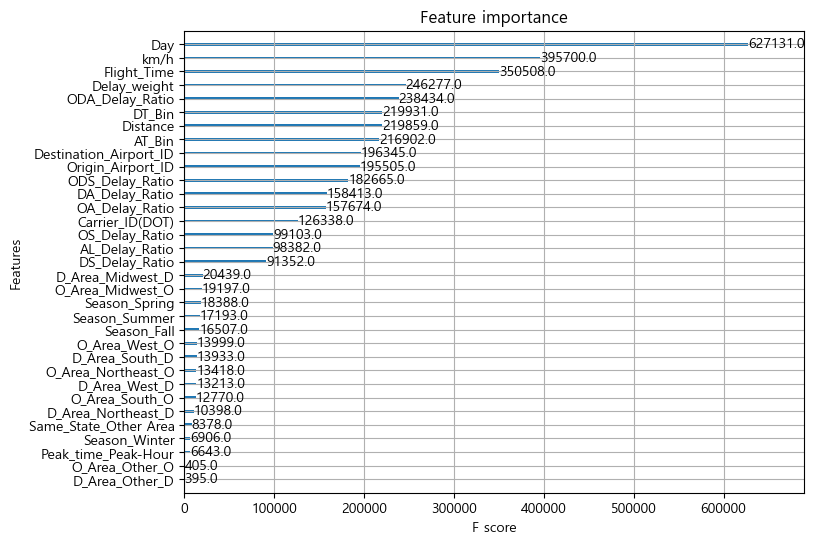

In [141]:
# Feature Importance
fig, ax = plt.subplots(figsize = (8, 6))
xgb_plot_importance(xgb_clf, ax = ax)

In [146]:
test_proba = pd.DataFrame(xgb_clf.predict_proba(test_df), columns = ['Not_Delayed', 'Delayed'])
test_proba

,Not_Delayed,Delayed
0,0.721286,0.278714
1,0.203260,0.796740
2,0.342291,0.657709
3,0.198859,0.801141
4,0.497650,0.502350
...,...,...
999995,0.431572,0.568428
999996,0.612983,0.387017
999997,0.504443,0.495557
999998,0.799055,0.200945


In [149]:
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)
submission = sample_submission.copy()
submission['Not_Delayed'] = test_proba['Not_Delayed'].values
submission['Delayed'] = test_proba['Delayed'].values
submission.to_csv('./submit/submit_0528_XGB.csv', index = True)

### CatBoostClassifier

In [67]:
select_col = ['Origin_Airport', 'Destination_Airport', 'Distance', 'Carrier_ID(DOT)', 'Day',
              'DT_Bin', 'AT_Bin', 'Flight_Time', 'km/h', 'Season', 'Peak_time', 'Same_State',
              'O_Area', 'D_Area', 'Delay_weight', 'Delay']

train_df = train_new[select_col]
test_df = test_new[[x for x in select_col if x not in 'Delay']]

train_df['Carrier_ID(DOT)'] = train_df['Carrier_ID(DOT)'].astype('int32')
test_df['Carrier_ID(DOT)'] = test_df['Carrier_ID(DOT)'].astype('int32')
print(train_df.shape, test_df.shape)

(1000000, 16) (1000000, 15)


In [68]:
train_labeled = train_df[train_df['Delay'].notnull()]
train_unlabeled = train_df[train_df['Delay'].isnull()]

train_labeled['Delay'] = train_labeled['Delay'].map({'Not_Delayed' : 0, 'Delayed' : 1})
train_labeled['Delay'] = train_labeled['Delay'].astype('int16')

counts = list(train_labeled['Delay'].value_counts())
class_weight = [counts[1] / sum(counts), counts[0] / sum(counts)]
print('Weight : ', class_weight)

Weight :  [0.1764698961964855, 0.8235301038035145]


In [69]:
X_data, y_data = train_labeled.drop('Delay', axis = 1), train_labeled['Delay']
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.1,
                                                      stratify = y_data, random_state = SEED)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(229500, 15) (25501, 15) (229500,) (25501,)


In [85]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 12),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    # CatBoostClassifier 사용
    model = CatBoostClassifier(**param, loss_function = 'Logloss', eval_metric = 'Logloss', 
                               class_weights = class_weight, use_best_model = True, random_state = SEED,
                               cat_features = [0, 1, 3, 4, 5, 6, 9, 10, 11, 12, 13]) # task_type = 'GPU'
    pruning_callback = CatBoostPruningCallback(trial, 'Logloss', eval_set_index = 1)
    cat_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    # Valid Set Logloss 계산
    score = log_loss(y_valid.ravel(), cat_model.predict_proba(X_valid))
    return score

In [86]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-05-28 21:45:34,375] A new study created in memory with name: no-name-e2bc75ec-248b-4aed-98b2-df5ddc80a74a
[I 2023-05-28 21:47:27,345] Trial 0 finished with value: 0.6418792224122346 and parameters: {'learning_rate': 0.01, 'depth': 2, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8182496720710062}. Best is trial 0 with value: 0.6418792224122346.
[I 2023-05-28 21:47:47,651] Trial 1 finished with value: 0.6869718700530112 and parameters: {'learning_rate': 0.1, 'depth': 4, 'colsample_bylevel': 0.001, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6418792224122346.
[I 2023-05-28 21:48:06,069] Trial 2 finished with value: 0.6928696769279483 and parameters: {'learning_rate': 0.01, 'depth': 12, 'colsample_bylevel': 0.001, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9183883618709039}. Best is trial 0 with value: 0.6418792224122346.
[I 2023-05-28 21:49:40,452] T

Best trial : score 0.604850883066152, 
 params = {'learning_rate': 0.5, 'depth': 9, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'} 



In [88]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)
valid_logloss = []

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) :
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params
    
    cat_clf = CatBoostClassifier(**param, loss_function = 'Logloss', eval_metric = 'Logloss', 
                                 class_weights = class_weight, use_best_model = True, random_state = SEED,
                                 cat_features = [0, 1, 3, 4, 5, 6, 9, 10, 11, 12, 13])
    cat_clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = False)
    
    # 모델 loss 출력
    valid_logloss.append(log_loss(y_valid.ravel(), cat_clf.predict_proba(X_valid)))
    print(f'Valid Set {fold + 1} 번째 모델 loss : {log_loss(y_valid.ravel(), cat_clf.predict_proba(X_valid))}')


print(f'모델 loss 평균 : {np.array(valid_logloss).mean()}')

 20%|██        | 1/5 [06:46<27:07, 406.85s/it]

Valid Set 0 번째 모델 loss : 0.6055668071044382


 40%|████      | 2/5 [13:33<20:19, 406.61s/it]

Valid Set 1 번째 모델 loss : 0.6137631521862733


 60%|██████    | 3/5 [20:17<13:31, 405.65s/it]

Valid Set 2 번째 모델 loss : 0.6126991480388976


 80%|████████  | 4/5 [27:01<06:44, 404.84s/it]

Valid Set 3 번째 모델 loss : 0.6089039906720222


100%|██████████| 5/5 [33:49<00:00, 405.89s/it]

Valid Set 4 번째 모델 loss : 0.6117255453354271
모델 loss 평균 : 0.6105317286674117


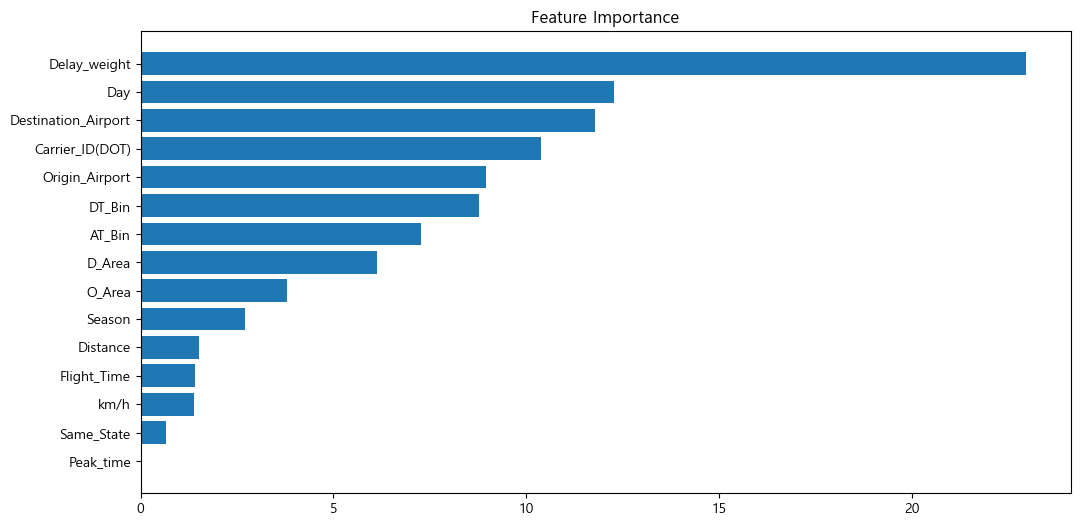

In [89]:
feature_importance = cat_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [90]:
test_proba = pd.DataFrame(cat_clf.predict_proba(test_df), columns = ['Not_Delayed', 'Delayed'])
test_proba

,Not_Delayed,Delayed
0,0.592624,0.407376
1,0.397586,0.602414
2,0.421034,0.578966
3,0.189304,0.810696
4,0.252757,0.747243
...,...,...
999995,0.447825,0.552175
999996,0.592003,0.407997
999997,0.476506,0.523494
999998,0.486956,0.513044


In [91]:
len(test_proba[test_proba['Delayed'] > 0.5])

462205

In [92]:
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)
submission = sample_submission.copy()
submission['Not_Delayed'] = test_proba['Not_Delayed'].values
submission['Delayed'] = test_proba['Delayed'].values
submission.to_csv('./submit/submit_0528_CAT_Optuna.csv', index = True)

### MLP

In [68]:
model = Sequential()
model.add(Input(shape = (35, )))
model.add(Flatten())
model.add(Dense(512, activation = 'gelu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'gelu'))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'gelu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation = 'gelu'))
model.add(Dropout(0.5))
# model.add(Dense(8, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 512)               18432     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [69]:
model.compile(optimizer = Adam(learning_rate = 1e-5, epsilon = 1e-7, decay = 0.01, clipnorm = 1.0), # tfa.optimizers.AdamW(learning_rate = 1e-5, weight_decay = 1e-7)
              loss = 'binary_crossentropy',
              metrics = [TruePositives(name = 'TP'), FalseNegatives(name = 'FN'),
                         FalsePositives(name = 'FP'), TrueNegatives(name = 'TN'),
                         Precision(name = 'Precision'), Recall(name = 'Recall'),])

# EarlyStop & Checkpoint
def lrscheduler(epoch, lr):
     if epoch < 5 : return lr
     else : return lr * tf.math.exp(-0.2)
scheduler = LearningRateScheduler(lrscheduler)

earlystop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min',
                          verbose = 1, restore_best_weights = True)
checkpoint = ModelCheckpoint(filepath = './model/model25_bce_W.h5', monitor = 'val_loss',
                             mode = 'min', verbose = True, save_best_only = True)

In [74]:
import gc
collected = gc.collect()
print('Garbage collector: collected', '%d objects.' % collected)

from keras import backend as K
K.clear_session()

Garbage collector: collected 72 objects.


In [70]:
model.fit(X_train, y_train,
          validation_data = (X_valid, y_valid),
          batch_size = 32,
          class_weight = class_weight_dict,
          callbacks = [scheduler, earlystop, checkpoint], # scheduler
          epochs = 50)

Epoch 1/50
7169/7172 [============================>.] - ETA: 0s - loss: 0.2504 - TP: 15773.0000 - FN: 24708.0000 - FP: 73467.0000 - TN: 115460.0000 - Precision: 0.1767 - Recall: 0.3896
Epoch 1: val_loss improved from inf to 0.77050, saving model to ./model\model25_bce_W.h5
7172/7172 [==============================] - 115s 16ms/step - loss: 0.2504 - TP: 15780.0000 - FN: 24720.0000 - FP: 73499.0000 - TN: 115501.0000 - Precision: 0.1767 - Recall: 0.3896 - val_loss: 0.7705 - val_TP: 4500.0000 - val_FN: 0.0000e+00 - val_FP: 21001.0000 - val_TN: 0.0000e+00 - val_Precision: 0.1765 - val_Recall: 1.0000 - lr: 1.0000e-05
Epoch 2/50
7172/7172 [==============================] - ETA: 0s - loss: 0.2493 - TP: 15993.0000 - FN: 24507.0000 - FP: 74519.0000 - TN: 114481.0000 - Precision: 0.1767 - Recall: 0.3949
Epoch 2: val_loss improved from 0.77050 to 0.76971, saving model to ./model\model25_bce_W.h5
7172/7172 [==============================] - 107s 15ms/step - loss: 0.2493 - TP: 15993.0000 - FN: 24507

In [71]:
test_proba = model.predict(test_df)
test_proba = pd.concat([pd.DataFrame(1 - test_proba, columns = ['Not_Delayed']),
                        pd.DataFrame(test_proba, columns = ['Delayed'])], axis = 1)
print(len(test_proba[test_proba['Delayed'] > 0.5]))
test_proba

31250/31250 [==============================] - 73s 2ms/step
999715


,Not_Delayed,Delayed
0,0.428083,0.571917
1,0.471307,0.528693
2,0.449776,0.550224
3,0.452438,0.547562
4,0.442212,0.557788
...,...,...
999995,0.468684,0.531316
999996,0.432756,0.567244
999997,0.459755,0.540245
999998,0.481524,0.518476


In [72]:
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)
submission = sample_submission.copy()
submission['Not_Delayed'] = test_proba['Not_Delayed'].values
submission['Delayed'] = test_proba['Delayed'].values
submission.to_csv('./submit/submit_0529_MLP.csv', index = True)

### Autogluon

In [79]:
from autogluon.tabular import TabularDataset, TabularPredictor

train_df = TabularDataset(train_labeled)
train_unlabeled_df = TabularDataset(train_unlabeled)
test_df = TabularDataset(test_df)

train_df['sample_weight'] = train_df['Delay'].map(class_weight_dict)

predictor = TabularPredictor(label = 'Delay', problem_type = 'binary', eval_metric = 'log_loss',
                             sample_weight = 'sample_weight',
                             path = './AutogluonModels/model_0529_weight') 

predictor.fit(train_data = train_df, presets = 'best_quality',
              auto_stack = True, fit_weighted_ensemble = True,
              num_bag_folds = 5, num_bag_sets = 3, num_stack_levels = 2,
              # excluded_model_types = ['FASTAI', 'NN_TORCH'],
              num_gpus = 1, num_cpus = 12, verbosity = 2)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=3
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "./AutogluonModels/model_0529_weight\"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    255001
Train Data Columns: 36
Label Column: Delay
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipel

#### (1) 모델별 성능 확인

In [80]:
# Leaderboard 확인
leaderboard = predictor.leaderboard(train_df, silent = True, extra_metrics = ['log_loss', 'f1', 'roc_auc', 'precision', 'recall'])
leaderboard.head(10)

,model,score_test,log_loss,f1,roc_auc,precision,recall,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-0.000059,-0.000059,0.999911,1.000000,1.000000,0.999822,-1.296801,18.679553,18.983588,0.071756,18.679553,18.983588,0.071756,1,True,2
1,XGBoost_BAG_L1,-0.327561,-0.327561,0.767615,0.969687,0.651959,0.933156,-0.536165,62.966957,34.617882,480.303663,62.966957,34.617882,480.303663,1,True,11
2,KNeighborsUnif_BAG_L1,-0.328655,-0.328655,0.318618,0.835158,0.651983,0.210822,-1.276873,19.806508,18.750869,0.073172,19.806508,18.750869,0.073172,1,True,1
3,RandomForestGini_BAG_L1,-0.333036,-0.333036,0.804646,0.970293,0.729226,0.897467,-0.501213,1.477332,9.842499,13.759985,1.477332,9.842499,13.759985,1,True,5
4,RandomForestEntr_BAG_L1,-0.341345,-0.341345,0.812151,0.973361,0.734344,0.908400,-0.503363,1.495938,9.875135,14.167077,1.495938,9.875135,14.167077,1,True,6
5,WeightedEnsemble_L2,-0.404919,-0.404919,0.070646,0.761191,0.677302,0.037267,-0.428037,92.402450,40.075883,2160.994225,0.013003,0.008002,10.644370,2,True,14
6,NeuralNetTorch_BAG_L2,-0.405140,-0.405140,0.068378,0.758110,0.649340,0.036089,-0.422472,166.616141,164.136377,3439.233340,13.824462,2.359937,910.868031,2,True,24
7,NeuralNetFastAI_BAG_L2,-0.418007,-0.418007,0.104508,0.737446,0.693672,0.056511,-0.422302,174.882938,165.628311,3289.936894,22.091259,3.851871,761.571586,2,True,22
8,NeuralNetFastAI_BAG_L1,-0.425087,-0.425087,0.052946,0.704224,0.613603,0.027667,-0.428854,18.944026,3.620471,744.193104,18.944026,3.620471,744.193104,1,True,10
9,NeuralNetTorch_BAG_L1,-0.425178,-0.425178,0.054709,0.702913,0.628111,0.028600,-0.429452,10.478464,1.829528,925.853088,10.478464,1.829528,925.853088,1,True,12


#### (2) Feature Importance 확인

In [81]:
# Feature Importance 확인
feature_importance = predictor.feature_importance(train_df)
feature_importance

These features in provided data are not utilized by the predictor and will be ignored: ['sample_weight']
Computing feature importance via permutation shuffling for 35 features using 5000 rows with 5 shuffle sets...
	4651.82s	= Expected runtime (930.36s per shuffle set)
	1599.14s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
ODA_Delay_Ratio,0.062853,0.005025,0.000005,5,0.073199,0.052506
D_Area_Other_D,0.000063,0.000301,0.332024,5,0.000682,-0.000556
O_Area_Other_O,-0.000032,0.000184,0.640302,5,0.000346,-0.000410
Peak_time_Peak-Hour,-0.000263,0.000839,0.738638,5,0.001466,-0.001991
O_Area_Northeast_O,-0.000384,0.001122,0.756522,5,0.001926,-0.002693
...,...,...,...,...,...,...
Carrier_ID(DOT),-0.028125,0.002800,0.999988,5,-0.022361,-0.033890
Flight_Time,-0.030650,0.001640,0.999999,5,-0.027274,-0.034026
Destination_Airport_ID,-0.033851,0.002788,0.999995,5,-0.028109,-0.039592
Origin_Airport_ID,-0.034816,0.002017,0.999999,5,-0.030662,-0.038970


#### (3) Confusion Matrix 확인
!['Confusion Matrix'](https://velog.velcdn.com/images/olxtar/post/cfd57195-37a4-41d6-9b72-6655a82c0a44/image.png)

In [82]:
# Confusion Matrix 확인
matrix = confusion_matrix(train_df['Delay'], predictor.predict(train_df))
matrix

array([[207308,   2693],
       [ 42462,   2538]], dtype=int64)

In [83]:
# Confusion Matrix
TN, FP, FN, TP = matrix.ravel()
precision = (TP) / (TP + FP)
recall = (TP) / (TP + FN)
f1 = (2 * precision * recall) / (precision + recall)
print('Precision : {:.2f}%'.format(precision*100))
print('Recall : {:.2f}%'.format(recall*100))
print('F1-Score : {:.2f}%'.format(f1*100))

Precision : 48.52%
Recall : 5.64%
F1-Score : 10.11%


#### (4) Test Set 예측

In [84]:
test_proba = predictor.predict_proba(test_df, as_multiclass = False)
test_proba

0         0.097226
1         0.112837
2         0.277459
3         0.627685
4         0.487087
            ...   
999995    0.270215
999996    0.062235
999997    0.222127
999998    0.206267
999999    0.144235
Name: Delay, Length: 1000000, dtype: float64

In [86]:
proba = pd.DataFrame(np.hstack([(1 - test_proba).values.reshape(-1, 1), test_proba.values.reshape(-1, 1)]),
                     columns = ['Not_Delayed', 'Delayed'])
print(len(proba[proba['Delayed'] > 0.5]))
proba

42581


,Not_Delayed,Delayed
0,0.902774,0.097226
1,0.887163,0.112837
2,0.722541,0.277459
3,0.372315,0.627685
4,0.512913,0.487087
...,...,...
999995,0.729785,0.270215
999996,0.937765,0.062235
999997,0.777873,0.222127
999998,0.793733,0.206267


In [ ]:
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)
submission = sample_submission.copy()
submission['Not_Delayed'] = proba['Not_Delayed'].values
submission['Delayed'] = proba['Delayed'].values
submission.to_csv('./submit/submit_0529_AG.csv', index = True)